# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify all symbols

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

# Work

## Preparation

In [1]:
# Install required packages (once per virtual environment)
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow xgboost scikeras
%reset -f


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, cross_validate
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
# Keras formatting helper
from scikeras.wrappers import KerasClassifier

# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings


/var/folders/z9/93thyyl57vd2c58_d39dsb7m0000gn/T/ipykernel_55833/380833911.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character. Using Unicode"""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))
    
def int_to_type(label):
    """Convert an integer label to type (letter/digit)"""
    if label < 10:
        return 'digit'
    else:
        return 'letter'
    
def class_to_int(emnist_classes): 
    """Define a function that takes a class and returns the integer label"""
    class_list = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
    label=[]
    for i in emnist_classes: 
        label.append(class_list.index(i))
    return label

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for symbols model (exercise 1)
def display_metrics_symbols(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            class_lab = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
            cm_df = pd.DataFrame(value, index=['actual {}'.format(i) for i in class_lab], columns=['predict {}'.format(i) for i in class_lab])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

# Define a function that takes row names and a labeled confusion matrix as input to generate a table of top classification classes 
def top_classes(row_names, source_df, class_n=5):
    """display top 5 classificaition classes & numbers for symbols listed 
    row_names = list of row names in the format of ['actual 1', 'actual A', 'actual a']
    source_df = labeled confusion matrix
    class_n = number of top classification classes, default set to 5
    """
    class_df = pd.DataFrame()
    for actuals in row_names: 
        display(Markdown(f'## Top {class_n} classificaition classes for {actuals}'))
        class_df['Class'] = source_df.loc[actuals,].sort_values(ascending=False).nlargest(class_n).index.tolist()
        class_df['Number'] = source_df.loc[actuals,].sort_values(ascending=False).nlargest(class_n).tolist()
        class_df['Percent(%)'] = class_df['Number']/sum(source_df.loc[actuals,])*100
        display(class_df)

# Display metrics for a type mode (exercise 2)
def display_metrics_type(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual digit', 'actual letter'], columns=['predicted digit', 'predicted letter'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'#### Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'#### Confusion Matrix: {model_name}'))
    display(cm_df)

def display_candidate_model_metrics(task, candidate_metrics_dict):
    """Display performance metrics candidate models trained by 3-fold cv and generate an average table to evaluate models."""
    metrics_df = pd.DataFrame()
    metric_means_df = pd.DataFrame()
    for model_name in candidate_metrics_dict[task]:
        metrics_df = pd.DataFrame(candidate_metrics_dict[task][model_name], index=['CV1', 'CV2', 'CV3']).T
        metrics_df['mean'] = metrics_df.mean(axis=1)
        metric_means_df[model_name] = metrics_df.mean(axis=1)
        display(Markdown(f'#### Performance Metrics: {model_name}'))
        display(metrics_df)
    display(Markdown(f'#### Summary Performance Metrics'))
    display(metric_means_df)

In [4]:
# Load training data
image, label = emnist.extract_training_samples('byclass')
train = pd.DataFrame()
train['class'] = np.array([int_to_char(l) for l in label])
train['image'] = list(image) 
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1)) 
train['label'] = label
# Count 
train.count()

class         697932
image         697932
image_flat    697932
label         697932
dtype: int64

In [5]:
# Load testing data
image, label = emnist.extract_test_samples('byclass')
valid = pd.DataFrame()
valid['class'] = np.array([int_to_char(l) for l in label])
valid['image'] = list(image) # 28*28 array
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1)) # array with length: 784
valid['label'] = label
# Count 
valid.count()

class         116323
image         116323
image_flat    116323
label         116323
dtype: int64

## Problem 1: Classify all symbols 
### 1.a Choose a model
Classification will be done using Neural Network. 

In [6]:
# Define all the metrics in a dictionary
metrics_dict = {
    'Classify_all_symbols' : { 
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }, 
    'Classify_all_symbols_validation_with_selected_data' : { 
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

### 1.b Train the model

In [7]:
# Comment if using whole dataset to train 
#train = train[:10000]
#print('Number of unique class values: ', len(train['class'].unique()))

# Comment if using whole dataset to validate 
#valid = valid[:3000]
#print('Number of unique class values: ', len(valid['class'].unique()))

In [8]:

# Neural Network
task = 'Classify_all_symbols'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images = np.array(train['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train['label'])
valid_images = np.array(valid['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid['label'])



# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(62, activation='softmax')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=10, batch_size=3500, validation_data=(valid_images, valid_labels))


Epoch 1/10
200/200 [==============================] - 5s 21ms/step - loss: 1.5421 - accuracy: 0.6046 - val_loss: 1.0972 - val_accuracy: 0.6966
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0749 - accuracy: 0.7033 - val_loss: 1.0511 - val_accuracy: 0.7097
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0474 - accuracy: 0.7117 - val_loss: 1.0338 - val_accuracy: 0.7160
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 1.0357 - accuracy: 0.7151 - val_loss: 1.0277 - val_accuracy: 0.7186
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0288 - accuracy: 0.7164 - val_loss: 1.0223 - val_accuracy: 0.7186
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0238 - accuracy: 0.7175 - val_loss: 1.0209 - val_accuracy: 0.7206
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 1.0221 - accuracy: 0.7175 - val_loss: 1.0245 - val_accuracy: 0.7167

### 1.c Evaluate the model
#### Overall evalation

3636/3636 [==============================] - 6s 2ms/step


# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.717115,0.699434,0.717115,0.697316


# Confusion Matrix: neural_network

,predict 0,predict 1,predict 2,predict 3,predict 4,predict 5,predict 6,predict 7,predict 8,predict 9,...,predict q,predict r,predict s,predict t,predict u,predict v,predict w,predict x,predict y,predict z
actual 0,4501,1,11,4,16,17,17,4,24,6,...,0,1,0,17,0,0,0,0,0,1
actual 1,0,5690,9,3,1,10,4,26,8,3,...,1,8,0,86,0,1,0,3,2,0
actual 2,21,12,5223,24,15,4,10,14,71,7,...,3,1,0,10,0,1,1,4,2,31
actual 3,27,12,66,5338,2,87,2,44,78,55,...,1,0,1,20,0,0,0,0,4,2
actual 4,6,3,11,0,4431,5,30,5,22,163,...,6,7,0,233,0,10,1,2,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
actual v,1,1,1,0,24,1,2,0,4,0,...,0,12,0,6,0,180,8,0,5,0
actual w,0,0,2,0,8,0,4,0,0,0,...,0,0,0,5,0,2,295,0,0,0
actual x,0,12,7,0,11,3,0,5,20,0,...,0,5,0,6,0,13,0,158,11,2
actual y,1,8,1,5,102,3,0,6,5,1,...,0,1,0,12,0,10,0,4,45,0


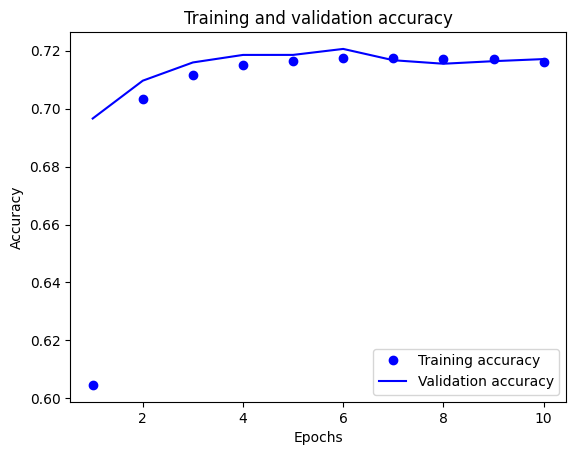

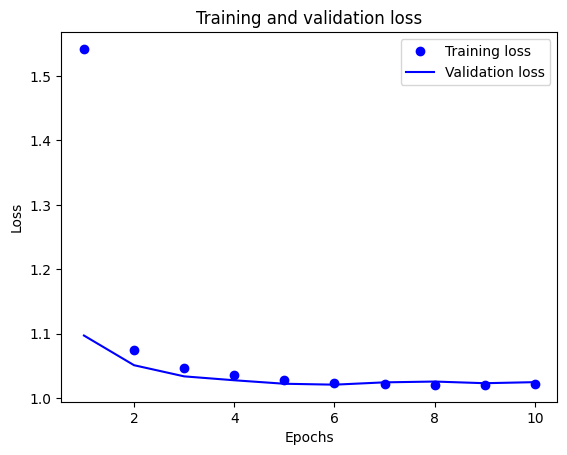

In [9]:
# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = np.argmax(model.predict(valid_images), axis=1)

# Calculate performance metrics
prec = precision_score(valid_labels, y_pred, average='weighted')
rec = recall_score(valid_labels, y_pred, average='weighted')
f1 = f1_score(valid_labels, y_pred, average='weighted')
cm = confusion_matrix(valid_labels, y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics_symbols(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

### 1.d Investigate subsets

In [10]:
class_lab = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
class_report = classification_report(valid_labels, y_pred, target_names=class_lab, zero_division=0)
print(class_report)

              precision    recall  f1-score   support

           0       0.60      0.78      0.68      5778
           1       0.61      0.90      0.73      6330
           2       0.80      0.89      0.84      5869
           3       0.90      0.89      0.90      5969
           4       0.79      0.79      0.79      5619
           5       0.75      0.74      0.74      5190
           6       0.87      0.92      0.89      5705
           7       0.92      0.93      0.92      6139
           8       0.79      0.85      0.82      5633
           9       0.83      0.92      0.87      5686
           A       0.65      0.68      0.67      1062
           B       0.62      0.54      0.58       648
           C       0.62      0.59      0.60      1739
           D       0.74      0.59      0.65       779
           E       0.83      0.53      0.65       851
           F       0.61      0.68      0.64      1440
           G       0.79      0.47      0.59       447
           H       0.58    

In [11]:
# Create the list of symbols with lowest recall`lowest_recall_char_rowname`
recall_scores_nn = recall_score(valid_labels, y_pred, average=None)
lowest_recall_char = [int_to_char(i) for i in np.argsort(recall_scores_nn)]
lowest_recall_char_rowname = ['actual {}'.format(i) for i in lowest_recall_char]

# create cm pandas dataframe 
cm_df = pd.DataFrame(cm, index=['actual {}'.format(i) for i in class_lab], columns=['pred {}'.format(i) for i in class_lab])

# Find top classification classes for n number of symbols with lowest recall 
n=15
display(top_classes(lowest_recall_char_rowname[0:n], cm_df))
# Specifying symbol and number of classification classes
display(top_classes(['actual m'], cm_df, class_n=10))

## Top 5 classificaition classes for actual u

,Class,Number,Percent(%)
0,pred U,324,67.219917
1,pred a,69,14.315353
2,pred 4,24,4.979253
3,pred 0,8,1.659751
4,pred V,7,1.452282


## Top 5 classificaition classes for actual s

,Class,Number,Percent(%)
0,pred S,313,71.624714
1,pred 5,51,11.670481
2,pred 3,14,3.203661
3,pred 6,6,1.372998
4,pred 2,5,1.144165


## Top 5 classificaition classes for actual o

,Class,Number,Percent(%)
0,pred 0,245,52.575107
1,pred O,189,40.557940
2,pred e,5,1.072961
3,pred a,4,0.858369
4,pred 2,4,0.858369


## Top 5 classificaition classes for actual m

,Class,Number,Percent(%)
0,pred M,419,90.301724
1,pred 4,8,1.724138
2,pred n,7,1.508621
3,pred N,6,1.293103
4,pred e,5,1.077586


## Top 5 classificaition classes for actual f

,Class,Number,Percent(%)
0,pred F,261,65.25
1,pred P,21,5.25
2,pred t,15,3.75
3,pred 2,13,3.25
4,pred 8,12,3.00


## Top 5 classificaition classes for actual g

,Class,Number,Percent(%)
0,pred 9,177,30.050934
1,pred 8,84,14.261460
2,pred 3,66,11.205433
3,pred g,36,6.112054
4,pred 0,24,4.074703


## Top 5 classificaition classes for actual q

,Class,Number,Percent(%)
0,pred 9,241,47.722772
1,pred 8,75,14.851485
2,pred q,38,7.524752
3,pred 4,29,5.742574
4,pred a,18,3.564356


## Top 5 classificaition classes for actual p

,Class,Number,Percent(%)
0,pred P,248,67.391304
1,pred p,40,10.869565
2,pred 0,13,3.532609
3,pred D,9,2.445652
4,pred 8,7,1.902174


## Top 5 classificaition classes for actual y

,Class,Number,Percent(%)
0,pred Y,136,35.695538
1,pred 4,102,26.771654
2,pred y,45,11.811024
3,pred t,12,3.149606
4,pred v,10,2.624672


## Top 5 classificaition classes for actual l

,Class,Number,Percent(%)
0,pred 1,1868,73.688363
1,pred l,354,13.964497
2,pred I,161,6.351085
3,pred L,29,1.143984
4,pred X,24,0.946746


## Top 5 classificaition classes for actual i

,Class,Number,Percent(%)
0,pred 1,176,41.217799
1,pred I,88,20.608899
2,pred i,64,14.988290
3,pred l,28,6.557377
4,pred j,10,2.341920


## Top 5 classificaition classes for actual c

,Class,Number,Percent(%)
0,pred C,255,59.027778
1,pred c,83,19.212963
2,pred e,41,9.490741
3,pred a,9,2.083333
4,pred O,6,1.388889


## Top 5 classificaition classes for actual z

,Class,Number,Percent(%)
0,pred 2,204,45.232816
1,pred z,95,21.064302
2,pred Z,32,7.095344
3,pred 8,21,4.656319
4,pred 4,9,1.995565


## Top 5 classificaition classes for actual Z

,Class,Number,Percent(%)
0,pred 2,261,56.250000
1,pred Z,100,21.551724
2,pred 8,25,5.387931
3,pred z,21,4.525862
4,pred t,7,1.508621


## Top 5 classificaition classes for actual I

,Class,Number,Percent(%)
0,pred 1,1152,56.250000
1,pred I,497,24.267578
2,pred l,132,6.445312
3,pred 2,78,3.808594
4,pred 5,33,1.611328


None

## Top 10 classificaition classes for actual m

,Class,Number,Percent(%)
0,pred M,419,90.301724
1,pred 4,8,1.724138
2,pred n,7,1.508621
3,pred N,6,1.293103
4,pred e,5,1.077586
5,pred U,4,0.862069
6,pred m,2,0.431034
7,pred 9,2,0.431034
8,pred H,2,0.431034
9,pred h,1,0.215517


None

Evaluate again, excluding easily confused symbols (such as 'O' and '0'): 


- Results show that accuracy increased by only including those that are easy to classify. 

In [12]:
# Re-evaluation: Exclude easily confused symbols

task = 'Classify_all_symbols_validation_with_selected_data'
model_name = 'neural_network'

# Exclude easily confused symbols in validation data 
excluded = class_to_int(list('0oOiI1lZ2z'))
mask_valid = valid['label'].apply(lambda x: x not in excluded)
valid_nonconfused = valid[mask_valid]

# Convert subset validation data to tensor
nonconfused_images = np.array(valid_nonconfused['image'])
nonconfused_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), nonconfused_images)))
nonconfused_images = nonconfused_images / 255.0
nonconfused_labels = np.array(valid_nonconfused['label'])

# Evaluate the model
loss, acc = model.evaluate(nonconfused_images, nonconfused_labels)
nonconfused_pred = np.argmax(model.predict(nonconfused_images), axis=1)

# Calculate performance metrics
prec = precision_score(nonconfused_labels, nonconfused_pred, average='weighted')
rec = recall_score(nonconfused_labels, nonconfused_pred, average='weighted')
f1 = f1_score(nonconfused_labels, nonconfused_pred, average='weighted')
cm = confusion_matrix(nonconfused_labels, nonconfused_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Make confusion matrix indices more readable
cm_labels = []
for i in np.unique(nonconfused_pred).tolist(): 
    cm_labels.append(int_to_char(i))
cm_labels

#Display performance metrics and confusion matrix for a model.
metrics_df = pd.DataFrame()
cm_df = pd.DataFrame()
for key, value in metrics_dict[task][model_name].items():
    if type(value) == np.ndarray:
        class_lab = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
        cm_df = pd.DataFrame(value, index=['actual {}'.format(i) for i in cm_labels], columns=['predict {}'.format(i) for i in cm_labels])
    else:
        metrics_df[key] = [value]
display(Markdown(f'# Performance Metrics: {model_name}'))
display(metrics_df)
display(Markdown(f'# Confusion Matrix: {model_name}'))
display(cm_df)

2744/2744 [==============================] - 4s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.741899,0.747542,0.741899,0.737913


# Confusion Matrix: neural_network

,predict 0,predict 1,predict 2,predict 3,predict 4,predict 5,predict 6,predict 7,predict 8,predict 9,...,predict q,predict r,predict s,predict t,predict u,predict v,predict w,predict x,predict y,predict z
actual 0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actual 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actual 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actual 3,27,12,66,5338,2,87,2,44,78,55,...,1,0,1,20,0,0,0,0,4,2
actual 4,6,3,11,0,4431,5,30,5,22,163,...,6,7,0,233,0,10,1,2,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
actual v,1,1,1,0,24,1,2,0,4,0,...,0,12,0,6,0,180,8,0,5,0
actual w,0,0,2,0,8,0,4,0,0,0,...,0,0,0,5,0,2,295,0,0,0
actual x,0,12,7,0,11,3,0,5,20,0,...,0,5,0,6,0,13,0,158,11,2
actual y,1,8,1,5,102,3,0,6,5,1,...,0,1,0,12,0,10,0,4,45,0


### 1.e Improve performance
Since we know that there are sets of symbols that are commonly confused such as `['1', 'l', 'I', 'i']` or `['o', 'O', 'O']`, we can use ensemble methods with a few model that specializes in differentiating between commonly misclassified symbols sets, and another overall model that handles the rest of the classification task. The final prediction could be a combination of the predictions from both models.

## 2. Classify digits vs. letters model showdown

### 1. Create a column for whether each row is a digit or a letter

In [13]:
# Load 'training/testing' data
image, label = emnist.extract_training_samples('byclass')
train = pd.DataFrame()
train['class'] = np.array([int_to_char(l) for l in label])
train['image'] = list(image) 
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1)) 
train['label'] = label
# Add a column with the type corresponding digit/letter
train['type'] = train['label'].apply(lambda x: int_to_type(x))
# Add a column 'isletter' with 0=digit, 1=letter
train['isletter']= train['label'].apply(lambda x: 0 if x<10 else 1)


# Load testing data
image, label = emnist.extract_test_samples('byclass')
valid = pd.DataFrame()
valid['class'] = np.array([int_to_char(l) for l in label])
valid['image'] = list(image) # 28*28 array
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1)) # array with length: 784
valid['label'] = label
# Add a column with the type corresponding digit/letter
valid['type'] = valid['label'].apply(lambda x: int_to_type(x))
 # Add a column 'isletter' with 0=digit, 1=letter
valid['isletter']= valid['label'].apply(lambda x: 0 if x<10 else 1)


### 2. Choose an evaluation metric 
### 3. Choose several candidate models to train
both specified in matrix dictionary

In [14]:
candidate_metrics_dict = {
    'digit_vs_letter' : { 
        'logistic_regression': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

### 4. Divide data to reserve a validation set that will NOT be used in training/testing

In [15]:
"""Merge data and subset out"""
merged = pd.concat([train, valid], axis=0, ignore_index=True)

# Group by class
grouped = merged.groupby('class')
# Number of samples from each group
n_sample=round(len(merged)/10/62, None)
# Sample a subset from each group
merged_sampled = grouped.apply(lambda x: x.sample(n_sample, random_state=42)).reset_index(drop=True)

# Display number samples 
print('Number of samples in `merged_sampled`: ', len(merged_sampled))
# Check that all 62 classes are present
print('Number of unique class values: ', len(merged_sampled['class'].unique()))

Number of samples in `merged_sampled`:  81406
Number of unique class values:  62


/var/folders/z9/93thyyl57vd2c58_d39dsb7m0000gn/T/ipykernel_55833/3028230982.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_sampled = grouped.apply(lambda x: x.sample(n_sample, random_state=42)).reset_index(drop=True)


In [16]:
# Divide data to reserve a validation set that will NOT be used in training/testing
shuffled_df = merged_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
# Create a 7:3 train:validation data split
split_index = round(len(shuffled_df)*0.7, None)
train = shuffled_df[:split_index]
valid = shuffled_df[split_index:]

# Check that all 62 classes are present
# In `train` (70% of the data)
print('Number of samples in `train`: ', len(train))
print('Number of unique class values: ', len(train['class'].unique()))
# In `valid` (30% of the data)
print('Number of samples in `valid`: ', len(valid))
print('Number of unique class values: ', len(valid['class'].unique()))

Number of samples in `train`:  56984
Number of unique class values:  62
Number of samples in `valid`:  24422
Number of unique class values:  62


### 5. K-fold train/test
        1. Create train/test splits from the non-validation dataset 
        2. Train each candidate model (best practice: use the same split for all models)
        3. Apply the model the the test split 
        4. (*Optional*) Perform hyper-parametric search
        5. Record the model evaluation metrics
        6. Repeat with a new train/test split


In [17]:
# Whole/subset data selection

# Comment for bigger model building
#train_subset = train[0:10000]
#valid_subset = valid[0:2000]

# Comment for small model building 
train_subset = train
valid_subset = valid

In [18]:
# Create train/test splits from the non-validation dataset 
# Initialize k-fold cross-validation: Create train/test splits from `train_subset`, use this cross-validaiton split for all models 
kfold = KFold(n_splits=3, shuffle=False)

In [19]:
# digit_vs_letter Classifier: RandomForest
task = 'digit_vs_letter'
model_name = 'random_forest'


# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model: perform k-fold cross-validation 
cvscore = cross_validate(rf_clf, 
                         train_subset['image_flat'].tolist(), 
                         train_subset['isletter'], 
                         scoring=('accuracy', 'precision', 'recall', 'f1'), 
                         cv=kfold, n_jobs=-2, return_indices=False)
acc = cvscore['test_accuracy']
prec = cvscore['test_precision']
rec = cvscore['test_recall']
f1 = cvscore['test_f1']

# Store performance metrics in dictionary
candidate_metrics_dict[task][model_name] = {'accuracy': acc,
                                            'precision': prec,
                                            'recall': rec,
                                            'f1': f1}


Python(55880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(55888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [20]:
# digit_vs_letter Classifier: Logistic Regression 
task = 'digit_vs_letter'
model_name = 'logistic_regression'

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Scale the data
# When running without scaling the data, the model does not converge
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_subset['image_flat'].tolist())

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate model: perform k-fold cross-validation 
cvscore = cross_validate(lr_clf, 
                         train_scaled, 
                         train_subset['isletter'], 
                         scoring=('accuracy', 'precision', 'recall', 'f1'), 
                         cv=kfold, n_jobs=-2, return_indices=False)
acc = cvscore['test_accuracy']
prec = cvscore['test_precision']
rec = cvscore['test_recall']
f1 = cvscore['test_f1']

# Store performance metrics in dictionary
candidate_metrics_dict[task][model_name] = {'accuracy': acc,
                                            'precision': prec,
                                            'recall': rec,
                                            'f1': f1}

In [21]:
# digit_vs_letter Classifier: XGBoost
task = 'digit_vs_letter'
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model: perform k-fold cross-validation 
cvscore = cross_validate(xgb_clf, 
                         train_subset['image_flat'].tolist(), 
                         train_subset['isletter'], 
                         scoring=('accuracy', 'precision', 'recall', 'f1'), 
                         cv=kfold, n_jobs=-2, return_indices=False)
acc = cvscore['test_accuracy']
prec = cvscore['test_precision']
rec = cvscore['test_recall']
f1 = cvscore['test_f1']

# Store performance metrics in dictionary
candidate_metrics_dict[task][model_name] = {'accuracy': acc,
                                            'precision': prec,
                                            'recall': rec,
                                            'f1': f1}



In [22]:
# digit vs letter Classifier: Neural Network
task = 'digit_vs_letter'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images = np.array(train_subset['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_type = np.array(train_subset['isletter'])

# Initialize neural network model
def build_nn_model(): 
    model = Sequential([
        keras.layers.InputLayer(input_shape=(28, 28, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model 

# wrap the Keras model inside a scikit-learn compatible wrapper 
keras_wrapped_nnmodel = KerasClassifier(build_fn=build_nn_model, epochs=5, verbose=1)

# Train and evaluate model: perform k-fold cross-validation 
cvscore = cross_validate(keras_wrapped_nnmodel, train_images, train_type,
                         scoring=('accuracy', 'precision', 'recall', 'f1'), 
                         cv=kfold, verbose=1, return_indices=False)

acc = cvscore['test_accuracy']
prec = cvscore['test_precision']
rec = cvscore['test_recall']
f1 = cvscore['test_f1']

# Store performance metrics in dictionary
candidate_metrics_dict[task][model_name] = {'accuracy': acc,
                                            'precision': prec,
                                            'recall': rec,
                                            'f1': f1}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3864 - accuracy: 0.8403
Epoch 2/5
1188/1188 [==============================] - 8s 6ms/step - loss: 0.3739 - accuracy: 0.8441
Epoch 3/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3733 - accuracy: 0.8439
Epoch 4/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3742 - accuracy: 0.8426
Epoch 5/5
594/594 [==============================] - 1s 1ms/step
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1188/1188 [==============================] - 8s 7ms/step - loss: 0.3876 - accuracy: 0.8390
Epoch 2/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3772 - accuracy: 0.8418
Epoch 3/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3776 - accuracy: 0.8411
Epoch 4/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3784 - accuracy: 0.8405
Epoch 5/5
594/594 [==============================] - 1s 1ms/step
Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1188/1188 [==============================] - 8s 7ms/step - loss: 0.3840 - accuracy: 0.8431
Epoch 2/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3716 - accuracy: 0.8454
Epoch 3/5
1188/1188 [==============================] - 8s 7ms/step - loss: 0.3731 - accuracy: 0.8447
Epoch 4/5
1188/1188 [==============================] - 8s 6ms/step - loss: 0.3729 - accuracy: 0.8445
Epoch 5/5
594/594 [==============================] - 1s 1ms/step


In [23]:
display_candidate_model_metrics(task, candidate_metrics_dict)


#### Performance Metrics: logistic_regression

,CV1,CV2,CV3,mean
accuracy,0.847539,0.851066,0.845583,0.848063
precision,0.863409,0.868056,0.860752,0.864072
recall,0.972295,0.970752,0.972529,0.971859
f1,0.914623,0.916536,0.913233,0.914797


#### Performance Metrics: xgboost

,CV1,CV2,CV3,mean
accuracy,0.902659,0.904659,0.900021,0.902446
precision,0.917332,0.920270,0.913422,0.917008
recall,0.971669,0.970939,0.972529,0.971712
f1,0.943719,0.944926,0.942049,0.943565


#### Performance Metrics: random_forest

,CV1,CV2,CV3,mean
accuracy,0.897289,0.896657,0.890281,0.894742
precision,0.899333,0.900399,0.892412,0.897381
recall,0.988341,0.986438,0.987776,0.987519
f1,0.941739,0.941457,0.937676,0.940290


#### Performance Metrics: neural_network

,CV1,CV2,CV3,mean
accuracy,0.823954,0.828534,0.845530,0.832673
precision,0.888287,0.892220,0.865101,0.881869
recall,0.904099,0.905881,0.965724,0.925235
f1,0.896123,0.898998,0.912647,0.902590


#### Summary Performance Metrics

,logistic_regression,xgboost,random_forest,neural_network
accuracy,0.848063,0.902446,0.894742,0.832673
precision,0.864072,0.917008,0.897381,0.881869
recall,0.971859,0.971712,0.987519,0.925235
f1,0.914797,0.943565,0.940290,0.902590


### 6. Promote winner, apply model to validation set: 
**Random forest model** has the <u>highest recall<u>

In [24]:
# Fit data on validation set

# digit_vs_letter Classifier: RandomForest
task = 'digit_vs_letter_final_model'
model_name = 'random_forest'


# Initialize random forest classifier
rf_cl_dvl = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and generate predictions
rf_cl_dvl.fit(train_subset['image_flat'].tolist(), train_subset['isletter'])
y_pred = rf_cl_dvl.predict(valid_subset['image_flat'].tolist())

# Evaluate model
acc = accuracy_score(valid_subset['isletter'], y_pred)
prec = precision_score(valid_subset['isletter'], y_pred)
rec = recall_score(valid_subset['isletter'], y_pred)
f1 = f1_score(valid_subset['isletter'], y_pred)
cm = confusion_matrix(valid_subset['isletter'], y_pred)

# Store evaluation metrics in dictionary 
final_model_metrics = {task:{model_name:{}}}
final_model_metrics[task][model_name] = {'accuracy': acc,
                                         'precision': prec,
                                         'recall': rec,
                                         'f1': f1,
                                         'confusion_matrix': cm}



### 7. (*Optional*) Perform hyper-parametric search, if applicable
N/A

### 8. Report model performance

In [25]:
#Display performance metrics and confusion matrix for a model.
metrics_df = pd.DataFrame()
cm_df = pd.DataFrame()
for key, value in final_model_metrics[task][model_name].items():
    if type(value) == np.ndarray:
        cm_df = pd.DataFrame(value, index=['actual digit', 'actual letter'], columns=['predicted digit', 'predicted letter'])
    else:
        metrics_df[key] = [value]
display(Markdown(f'# Performance Metrics: {model_name}'))
display(metrics_df)
display(Markdown(f'# Confusion Matrix: {model_name}'))
display(cm_df)

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.899107,0.902084,0.986601,0.942451


# Confusion Matrix: random_forest

,predicted digit,predicted letter
actual digit,1782,2190
actual letter,274,20176
